In [1]:
# Install required packages in the current Jupyter kernel
# Uncomment the following lines if you need to install these libraries
# If you run into permission issues, try with the --user option
# import sys
# !pip install -q rdflib networkx matplotlib
# !{sys.executable} -m pip install rdflib networkx matplotlib --user

# Imports
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections

In [2]:
datapath = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/STRING/rdf/protein.links.rdf.v11.5/402676.protein.links.rdf.v11.5.txt.gz'
# RDF graph loading
import gzip
from rdflib.namespace import RDF
with gzip.open(datapath,'rb') as inputdata:
    rg = RDFGraph()
    rg.parse(inputdata.read(), format='turtle')
    print("rdflib Graph loaded successfully with {} triples".format(len(rg)))

rdflib Graph loaded successfully with 2620310 triples


In [7]:
preds = rg.predicates(subject=None, object=None, unique=True)
preds = [ p for  p in preds]
print(preds)

[rdflib.term.URIRef('https://string-db.org/rdf/any-confidence'), rdflib.term.URIRef('https://string-db.org/rdf/medium-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/high-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/highest-confidence-cutoff')]


In [18]:
#get a subject and expand
import random

#recursive function to get some neighbours
def grab_neighbours(seed,rg, limit = 10, recur = 0 , maxrecur = 3 , sample_run = 100 ):
    nodes = []
    #sample the neighbourhood randomly
    objs =  rg.objects(subject = seed ) 
    objs = [  next(objs) for i in range(sample_run) ]
    random.shuffle(objs)
    
    for i,obj in enumerate(objs):
        if i < limit and recur < maxrecur:
            nodes += grab_neighbours(obj,rg,limit = limit, recur = recur+1 )    
        elif i < limit:
            nodes.append( obj )
        if i > limit:
            break
    return nodes

def sample( subject_iter = None , seed = None, layers = 3 , layer_limit = 3 , verbose = True):
    if not seed:
        seed = next(subject_iter)
    if verbose == True:
        print('seed', seed)
    nodes = grab_neighbours(seed,rg, limit = layer_limit, recur = 0 , maxrecur = layers)
    subG = RDFGraph()
    triples = [ rg.triples((n1,None,n2)) for n1 in nodes for n2 in nodes if n1 != n2 ]
    for t in triples:
        subG+=t
    return subG
    


In [53]:
import rdflib
subjs = rg.subjects( unique = True)
subg = sample(subject_iter = subjs , layer_limit= 2)
print(subg)
G = rdflib.extras.external_graph_libs.rdflib_to_networkx_multidigraph( subg , lambda s, p, o: {'data':{'key':p  , 'weight':1} } )

seed https://string-db.org/network/402676.B6K8C9
[a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']].


In [54]:
print(dir(G))
print([e for i,e in enumerate(G.edges(data = True , keys=True)) if i < 10])

['__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adj', '_node', '_pred', '_succ', 'add_edge', 'add_edges_from', 'add_node', 'add_nodes_from', 'add_weighted_edges_from', 'adj', 'adjacency', 'adjlist_inner_dict_factory', 'adjlist_outer_dict_factory', 'clear', 'clear_edges', 'copy', 'degree', 'edge_attr_dict_factory', 'edge_key_dict_factory', 'edge_subgraph', 'edges', 'get_edge_data', 'graph', 'graph_attr_dict_factory', 'has_edge', 'has_node', 'has_predecessor', 'has_successor', 'in_degree', 'in_edges', 'is_directed', 'is_multigraph', 'name', 'nbunch_iter', 'neighbors', 'new_edge_key', 'node_attr_dict_factory', 'node_dict_factory', 'nodes', 'n

In [55]:
import colour
import itertools

red = colour.Color('red')
blue = colour.Color('blue')

c = [ c.hex_l for c in  list(red.range_to(blue, len(preds))) ]
colors = { p:c[i] for i,p in enumerate(preds)}
delta = 2/len(preds)
curve = { p:delta*i for i,p in enumerate(preds) }
style = itertools.cycle([ '-', '--' ])
line_style = { p:next(style) for p in preds }

In [56]:
print(colors)

{rdflib.term.URIRef('https://string-db.org/rdf/any-confidence'): '#ff0000', rdflib.term.URIRef('https://string-db.org/rdf/medium-confidence-cutoff'): '#aaff00', rdflib.term.URIRef('https://string-db.org/rdf/high-confidence-cutoff'): '#00ffaa', rdflib.term.URIRef('https://string-db.org/rdf/highest-confidence-cutoff'): '#0000ff'}


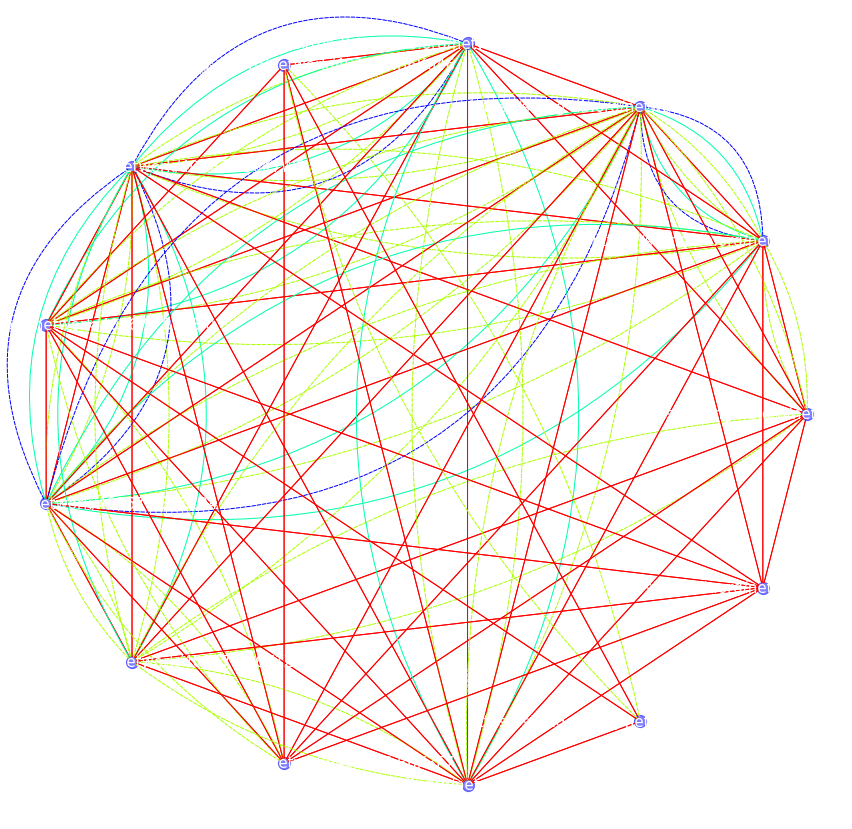

In [57]:

pos = nx.circular_layout( G )

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.plot()

#plot the whole mess
ax = plt.gca()

for e in G.edges(data = True):
    ax.annotate("",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(arrowstyle="-", color=colors[e[2]['data']['key']],
                                shrinkA=5, shrinkB=5, lw = e[2]['data']['weight'], ls = line_style[e[2]['data']['key']],
                                patchA=None, patchB=None, alpha = e[2]['data']['weight'],
                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*curve[e[2]['data']['key']])
                                ),
                                ),
                )

nx.draw_networkx_nodes(G, pos, node_color = 'b', node_size = 150, alpha = .5)
labels=nx.draw_networkx_labels(G , pos = pos , font_size= 15 , font_color='w')

plt.axis('off')
plt.show()


In [ ]:
i = 0 
from rdflib.namespace import RDF

for s, p, o in rg.triples((None,  RDF.type, None)):
    print(f"{s} is a {o}")
    if i > 10:
        break

In [ ]:
#tripe types to expand

#subsample 


# inplace expand ... G1 += G2

from rdflib import URIRef
from rdflib.namespace import RDF

bob = URIRef("http://example.org/people/bob")
if (bob, RDF.type, FOAF.Person) in graph:
    print("This graph knows that Bob is a person!")

In [ ]:
G = rdflib_to_networkx_graph(rg)

## 2. Get a subgraph out of the loaded RDF graph (optional)

This cell can be skipped altogether without affecting the rest of the notebook; but it will be useful if instead of using the whole RDF grahp of the previous step, we just want to use a subgraph that's included in it.

By executing the next cell, we'll be asked two things:

- The URI of the ''entiy'' type we are interested in (e.g. `http://dbpedia.org/ontology/Band`)
- The URI of the ''relation'' connecting entities we are interested in (e.g. `http://dbpedia.org/ontology/influencedBy`)

Using these two, the notebook will replace the original graph with the subgraph that's constructed by those entity types and relations only.

In [ ]:
# Subgraph construction (optional)
entity = input("Entity type to build nodes of the subgraph with: ")
relation = input("Relation type to build edges of the subgraph with: ")

# TODO: Use entity and relation as parameters of a CONSTRUCT query
query = """
PREFIX bsbm: <http://www4.wiwiss.fu-berlin.de/bizer/bsbm/v01/vocabulary/>
CONSTRUCT {{ ?u a {} . ?u {} ?v }} WHERE {{ ?u a {} . ?u {} ?v }}""".format(entity, relation, entity, relation)
# print(query)
subg = rg.query(query)

rg = subg

## 3. Converting rdflib.Graph to networkx.Graph

Thanks to [the great work done by the rdflib developers](https://github.com/RDFLib/rdflib/blob/master/rdflib/extras/external_graph_libs.py) this step, which converts the basic graph data structure of rdflib into its equivalent in networkx, is straightforward. Just run the next cell to make our RDF dataset ready for network analysis!

In [ ]:
# Conversion of rdflib.Graph to networkx.Graph
G = rdflib_to_networkx_graph(rg)
print("networkx Graph loaded successfully with length {}".format(len(G)))

networkx Graph loaded successfully with length 16


## 4. Network analysis

At this point we can run the network analysis on our RDF graph by using the networkx algorithms. Exeucting the next cell will output a full network analysis report, with the following parts:

- General network metrics (network size, pendants, density)
- Node centrality metrics (degree, eigenvector, betwenness). For these, averages, stdevs, maximum, minimum and distribution histograms are given
- Clustering metrics (connected components, clustering)
- Overall network plot

The report can be easily selected and copy-pasted for further use in other tools.

NETWORK SIZE
The network has 16 nodes and 18 edges

PENDANTS
The network has 10 pendants

DENSITY
The network density is 0.15

DEGREE CENTRALITY
The mean degree centrality is 0.15000000000000005, with stdev 0.17805533888009004
The maximum node is http://aOffer2414, with value 0.6
The minimum node is 2008-02-22, with value 0.06666666666666667
(0.6, 0.13333333333333333, 0.06666666666666667) (2, 4, 10)


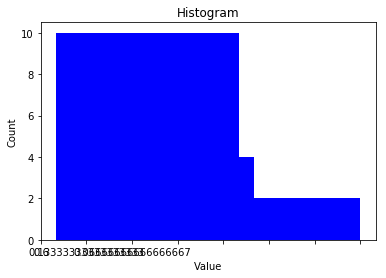


EIGENVECTOR CENTRALITY
The mean network eigenvector centrality is 0.2185095746777181, with stdev 0.12544774539932385
The maximum node is http://aOffer2414, with value 0.49999922740548974
The minimum node is 2008-02-22, with value 0.1386752633351396
(0.49999922740548974, 0.2773505266702785, 0.1386752633351396) (2, 4, 10)


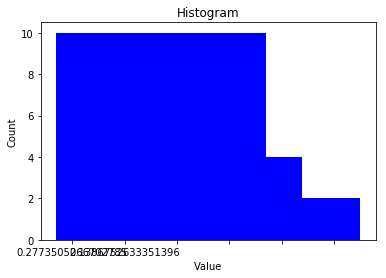


BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.09642857142857143, with stdev 0.20010201479877862
The maximum node is http://aOffer2414, with value 0.6000000000000001
The minimum node is 2008-02-22, with value 0.0
(0.6000000000000001, 0.08571428571428572, 0.0) (2, 4, 10)


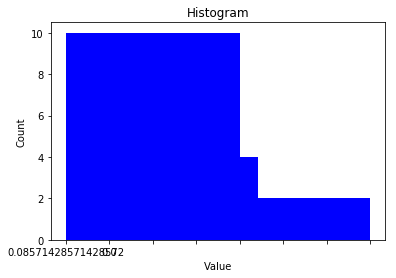


CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 16 nodes

CLUSTERS
The graph has 16 clusters
Cluster 0 has 17 nodes
Cluster 1 has 10 nodes
Cluster 2 has 10 nodes
Cluster 3 has 20 nodes
Cluster 4 has 17 nodes
Cluster 5 has 10 nodes
Cluster 6 has 10 nodes
Cluster 7 has 1 nodes
Cluster 8 has 63 nodes
Cluster 9 has 10 nodes
Cluster 10 has 40 nodes
Cluster 11 has 26 nodes
Cluster 12 has 40 nodes
Cluster 13 has 26 nodes
Cluster 14 has 5 nodes
Cluster 15 has 5 nodes

Visualizing the graph:


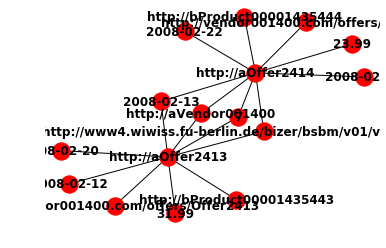

In [ ]:
# Analysis

def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def number_of_pendants(g):
    """
    Equals the number of nodes with degree 1
    """
    pendants = 0
    for u in g:
        if g.degree[u] == 1:
            pendants += 1
    return pendants


def histogram(l):
    degree_sequence = sorted([d for n, d in list(l.items())], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    print(deg, cnt)
    
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Histogram")
    plt.ylabel("Count")
    plt.xlabel("Value")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

# Network size
print("NETWORK SIZE")
print("============")
print("The network has {} nodes and {} edges".format(G.number_of_nodes(), G.number_of_edges()))
print()

# Network size
print("PENDANTS")
print("============")
print("The network has {} pendants".format(number_of_pendants(G)))
print()

# Density
print("DENSITY")
print("============")
print("The network density is {}".format(nx.density(G)))
print()

# Degree centrality -- mean and stdev
dc = nx.degree_centrality(G)
degrees = []
for k,v in dc.items():
    degrees.append(v)
    
print("DEGREE CENTRALITY")
print("=================")
print("The mean degree centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
print("The maximum node is {}, with value {}".format(max(dc, key=dc.get), max(dc.values())))
print("The minimum node is {}, with value {}".format(min(dc, key=dc.get), min(dc.values())))
histogram(dc)
print()

# Eigenvector centrality -- mean and stdev
ec = nx.eigenvector_centrality(G)
degrees = []
for k,v in ec.items():
    degrees.append(v)
    
print("EIGENVECTOR CENTRALITY")
print("======================")
print("The mean network eigenvector centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
print("The maximum node is {}, with value {}".format(max(ec, key=ec.get), max(ec.values())))
print("The minimum node is {}, with value {}".format(min(ec, key=ec.get), min(ec.values())))
histogram(ec)
print()

# Betweenness centrality -- mean and stdev
bc = nx.betweenness_centrality(G)
degrees = []
for k,v in bc.items():
    degrees.append(v)
print("BETWEENNESS CENTRALITY")
print("======================")
print("The mean betwenness centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
print("The maximum node is {}, with value {}".format(max(bc, key=bc.get), max(bc.values())))
print("The minimum node is {}, with value {}".format(min(bc, key=bc.get), min(bc.values())))
histogram(bc)
print()


# Connected components
cc = list(nx.connected_components(G))
print("CONNECTED COMPONENTS")
print("====================")
print("The graph has {} connected components".format(len(cc)))
for i,c in enumerate(cc):
    print("Connected component {} has {} nodes".format(i,len(c)))
print()

# Clusters
cl = nx.clustering(G)
print("CLUSTERS")
print("========")
print("The graph has {} clusters".format(len(cl)))
for i,c in enumerate(cl):
    print("Cluster {} has {} nodes".format(i,len(c)))
print()
    
# Plot
print("Visualizing the graph:")
plt.plot()
nx.draw(G, with_labels=True, font_weight='bold')